# 0. GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2021-12-01 19:18:39.795790: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 380133071022579480]

# 1. Create Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import glob
import random
from skimage.io import imread, imshow
from skimage.color import rgb2lab

## 1.1. data path

In [34]:
test_data_path = './data/test_and_save_data/original_data'
test_image_paths = glob.glob(os.path.join(test_data_path, '*'))
test_image_paths = sorted(test_image_paths)
test_image_paths

['./data/test_and_save_data/original_data/img_01.JPEG',
 './data/test_and_save_data/original_data/img_02.JPEG',
 './data/test_and_save_data/original_data/img_03.JPEG',
 './data/test_and_save_data/original_data/img_04.JPEG',
 './data/test_and_save_data/original_data/img_05.JPEG',
 './data/test_and_save_data/original_data/img_06.JPEG',
 './data/test_and_save_data/original_data/img_07.JPEG',
 './data/test_and_save_data/original_data/img_08.JPEG',
 './data/test_and_save_data/original_data/img_09.JPEG',
 './data/test_and_save_data/original_data/img_10.JPEG',
 './data/test_and_save_data/original_data/img_11.JPEG',
 './data/test_and_save_data/original_data/img_12.JPEG',
 './data/test_and_save_data/original_data/img_13.JPEG',
 './data/test_and_save_data/original_data/img_14.JPEG']

## 1.2. Custom Dataset Class

In [4]:
class Custom_Image_Dataset(Dataset) :
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = imread(self.image_paths[idx])
        
        img_lab = rgb2lab(img)
        img_lab_norm = img_lab
        
        img_lab_norm[:, :, 0] = (img_lab_norm[:, :, 0]-50)/100
        img_lab_norm[:, :, 1] = img_lab_norm[:, :, 1]/110
        img_lab_norm[:, :, 2] = img_lab_norm[:, :, 2]/110
        
        img_l = np.expand_dims(img_lab_norm[:,:,0], axis = 2)
        img_ab = img_lab_norm[:, :, 1:]
        
        x = img_l
        y = img_ab
        
        if self.transforms is not None :
            x = self.transforms(x).float()
            y = self.transforms(y).float()
        
        return x, y

## 1.3. Data Load

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
test_dataset = Custom_Image_Dataset(test_image_paths, transform)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

# 2. Load Model

In [7]:
import torch
import torch.nn as nn

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2.1. define model function

In [9]:
class JKPSNET(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        def conv_2xs(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_dim)
            )
            return model
        
        def conv_2x(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, in_dim, kernel_size=3, stride=2, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_dim)
            )
            return model
        
        def conv_3xdil(dim) :
            model = nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(dim, dim, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(dim, dim, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(dim)
            )
            return model
        
        def conv_up(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_dim)
            )
            return model
        
        self.input = nn.Sequential()
        self.enc1 = conv_2xs(1, 64)
        self.enc2 = conv_2x(64, 128)
        self.enc3 = conv_2x(128, 256)
        self.enc4 = conv_2x(256, 512)
        self.convR = nn.Sequential(conv_3xdil(512))
       
        
        self.ups1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True)
        self.dec1 = conv_up(512, 256)
        self.ups2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True)
        self.dec2 = conv_up(256, 128)
        self.ups3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True)
        self.dec3 = conv_up(128, 64)

        self.abp = nn.Conv2d(64, 313, kernel_size=1, stride=1, padding=0, bias=True)
        self.softmax = nn.Softmax(dim=1)
        
        self.out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        
        self.print_cat = nn.Sequential()
        
        
        
    def forward(self, x):
        x = self.input(x)
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x = self.enc4(x3)
        x = self.convR(x)
        
        x = self.ups1(x)
        x = self.print_cat(torch.cat([x, x3], dim = 1))
        x = self.dec1(x)
        x = self.ups2(x)
        x = self.print_cat(torch.cat([x, x2], dim = 1))
        x = self.dec2(x)
        x = self.ups3(x)
        x = self.print_cat(torch.cat([x, x1], dim = 1))
        x = self.dec3(x)
        
        x = self.abp(x)
        
        x = self.out(self.softmax(x))
        
        
        return x

## 2.2. model compile

In [10]:
trained_model_JKPSNET = JKPSNET().to(device)

## 2.3. load trained state dict path

In [11]:
trained_state_dict_path = './data/model_saved/checkpoint_JKPSNET_LAB.pt'

## 2.3. load saved model 

In [12]:
trained_model_JKPSNET.load_state_dict(torch.load(trained_state_dict_path, map_location=device))

<All keys matched successfully>

# 3. Test

In [13]:
import numpy as np
from tqdm.notebook import tqdm

## 3.1. test function

In [14]:
def test_model(model, test_dataloader) :
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    test_data_list = []
    test_output_list = []
    test_target_list = []
    model.eval()
    
    test_dataloader_tqdm = tqdm(test_dataloader, desc="Test  ")
    for test_data, test_target in test_dataloader_tqdm :
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        
        test_output = model(test_data)
        
        test_data_list.append(test_data.cpu().detach().numpy())
        test_output_list.append(test_output.cpu().detach().numpy())
        test_target_list.append(test_target.cpu().detach().numpy())
        
        del test_data
        del test_target
        del test_output
        torch.cuda.empty_cache()
    
    x = np.concatenate(test_data_list, axis = 0)
    y_predicted = np.concatenate(test_output_list, axis = 0)
    y_real = np.concatenate(test_target_list, axis = 0)
    
    torch.cuda.empty_cache()
    print("predict completed")
    
    return x, y_predicted, y_real

## 3.2. predict

In [15]:
x_test_L, y_test_predicted_AB, y_test_real_AB = test_model(trained_model_JKPSNET, test_dataloader)

Test  :   0%|          | 0/4 [00:00<?, ?it/s]

predict completed


In [16]:
y_test_predicted_AB.shape

(14, 2, 128, 128)

In [17]:
y_test_predicted_AB

array([[[[ 5.87807447e-02,  5.99412806e-02,  5.76323122e-02, ...,
           2.87651028e-02,  3.86728980e-02,  5.66450357e-02],
         [ 5.84117919e-02,  5.46361692e-02,  5.01979999e-02, ...,
           2.87244543e-02,  2.98477653e-02,  4.17282656e-02],
         [ 5.63008264e-02,  5.28834984e-02,  4.88394611e-02, ...,
           2.49611661e-02,  2.88955774e-02,  3.25815454e-02],
         ...,
         [-2.78999545e-02, -2.63937805e-02, -2.56050266e-02, ...,
          -7.88154267e-03, -7.40400469e-03, -3.01417010e-03],
         [-2.43249089e-02, -1.94135848e-02, -2.27441117e-02, ...,
          -2.92650051e-03, -4.89964103e-03,  3.54936393e-03],
         [-3.17813363e-03, -1.55453319e-02, -2.42796503e-02, ...,
           2.94578634e-03,  3.45891621e-03,  2.34320592e-02]],

        [[-2.23804146e-01, -2.69569606e-01, -2.79886365e-01, ...,
          -3.31648290e-01, -3.14302117e-01, -2.54217207e-01],
         [-2.58013666e-01, -2.91061848e-01, -2.94206262e-01, ...,
          -3.30111504e

## 3.3. LAB De-Normalization and Conatenate 

In [18]:
def lab_concat_de_norm(L, AB) :

    l = L.copy()
    ab = AB.copy()
    l[:,0,:,:] = l[:,0,:,:]*100+50

    ab[:,0,:,:] = ab[:,0,:,:]*110
    ab[:,1,:,:] = ab[:,1,:,:]*110

    lab = np.concatenate((l, ab), axis = 1)    
    return lab

In [19]:
y_test_predicted_LAB = lab_concat_de_norm(x_test_L, y_test_predicted_AB)
y_test_real_LAB = lab_concat_de_norm(x_test_L, y_test_real_AB)

## 3.4. 채널 위치 변경 

In [20]:
print(y_test_predicted_LAB.shape)
print(y_test_real_LAB.shape)

(14, 3, 128, 128)
(14, 3, 128, 128)


In [21]:
y_test_predicted_LAB = y_test_predicted_LAB.swapaxes(1, 3).swapaxes(1, 2)
y_test_real_LAB = y_test_real_LAB.swapaxes(1, 3).swapaxes(1, 2)
print(y_test_predicted_LAB.shape)
print(y_test_real_LAB.shape)

(14, 128, 128, 3)
(14, 128, 128, 3)


## 3.5. LAB2RGB

In [22]:
from skimage.color import lab2rgb

In [23]:
def lab_2_rgb(y_test_LAB) :
    
    
    y_test_RGB = np.empty((0, 128, 128, 3), dtype=np.float32)
    for img_lab in y_test_LAB :
        img_rgb = lab2rgb(img_lab)
        img_rgb = np.expand_dims(img_rgb, axis = 0)
        y_test_RGB = np.append(y_test_RGB, img_rgb, axis=0)
    
    return y_test_RGB

In [24]:
y_test_predicted = lab_2_rgb(y_test_predicted_LAB)
y_test_real = lab_2_rgb(y_test_real_LAB)

In [36]:
y_test_predicted.dtype

dtype('float32')

## 3.6. X_test

In [25]:
x_test = x_test_L.copy()
x_test[:,0,:,:] = x_test[:,0,:,:]*100

# 4. Visualizing Test Result

## 4.1. test result visualizing function

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
from tensorflow.keras import backend

In [27]:
def show_images(x, y_predicted, y_real, sn = 0):  

    x = x[:, 0, ...]
    
    n = y_predicted.shape[0]
    plt.figure(figsize=(20, 6))
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        if x.ndim < 4:
            plt.imshow(x[i+sn], cmap='gray')
        else:
            plt.imshow(x[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(y_predicted[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(y_real[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

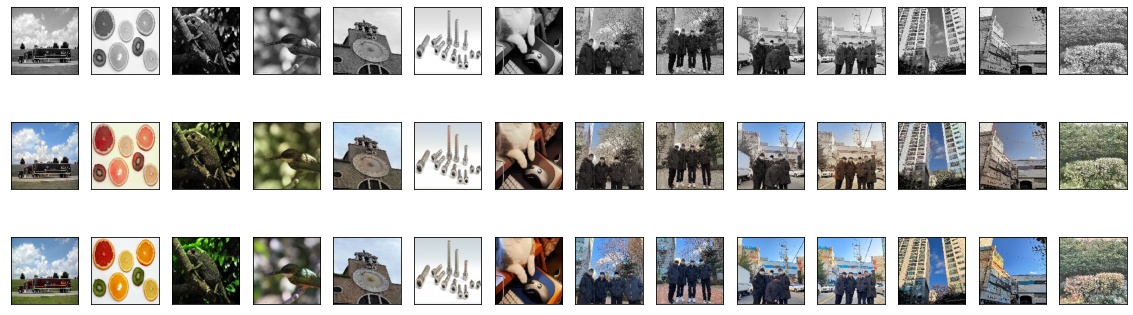

In [37]:
show_images(x_test, y_test_predicted, y_test_real)

# 5. Save Test Result

In [29]:
from skimage.io import imsave

In [50]:
def save_restored_images(y_predicted, image_save_path, image_name) :
    n = y_predicted.shape[0]
    for i in range(n) :
        img = (y_predicted[i]*255).astype(np.uint8)
        
        if i+1 < 10 :
            image_name_full = "{}_0{}.JPEG".format(image_name, i+1)
        else :
            image_name_full = "{}_{}.JPEG".format(image_name, i+1)
            
        imsave("{}/{}".format(image_save_path, image_name_full), img)
        
        print(image_name_full, " 저장 완료")

In [51]:
image_save_path = "./data/test_and_save_data/restored_data_jkps_lab"
image_name = "image_jkps_lab"

In [53]:
save_restored_images(y_test_predicted, image_save_path, image_name)

image_jkps_lab_01.JPEG  저장 완료
image_jkps_lab_02.JPEG  저장 완료
image_jkps_lab_03.JPEG  저장 완료
image_jkps_lab_04.JPEG  저장 완료
image_jkps_lab_05.JPEG  저장 완료
image_jkps_lab_06.JPEG  저장 완료
image_jkps_lab_07.JPEG  저장 완료
image_jkps_lab_08.JPEG  저장 완료
image_jkps_lab_09.JPEG  저장 완료
image_jkps_lab_10.JPEG  저장 완료
image_jkps_lab_11.JPEG  저장 완료
image_jkps_lab_12.JPEG  저장 완료
image_jkps_lab_13.JPEG  저장 완료
image_jkps_lab_14.JPEG  저장 완료
